# IAU 2023/2024
## **Autori:** Laura Fulajtárová (50%), Bruno Kristián (50%)

# Fáza 2 - Predspracovanie údajov

In [186]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import iqr
import statsmodels.stats as sm_stats
from sklearn import preprocessing
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [187]:
product = pd.read_csv("product_phase_1.csv", sep='\t')
user = pd.read_csv("user_phase_1.csv", sep='\t')
session = pd.read_csv("session_phase_1.csv", sep='\t')

### Datasets merge

In [188]:
set1 = set(session['product_ean'])
set2 = set(product['product_ean'])
common_values = set1.intersection(set2)

if common_values:
    print("Common values found in 'product_ean'.")
else:
    print("No common values found in 'product_ean'.")

No common values found in 'product_ean'.


Zistili sme, že datasety nevieme spojiť na základe stĺpca "product_ean", pretože sme nenašli žiadne spoločné hodnoty.  

In [189]:
set1 = set(session['user_id'])
set2 = set(user['old_user_id'])
common_values = set1.intersection(set2)

if common_values:
    print("Common values found in 'user_id'.")
else:
    print("No common values found in 'user_id'.")

Common values found in 'user_id'.


Vedeli by sme spojiť datasety na základe stĺpca "user_id" a "old_user_id". Tieto dva stĺpce sú v oboch datasetoch a majú spoločné hodnoty. 

In [190]:
user.rename(columns={'user_id': 'new_user_id', 'old_user_id': 'user_id'}, inplace=True)

In [191]:
merged_data= pd.merge(user, session, on='user_id', how='inner')

Spojili sme datasety na základe stĺpa "user_id". Použili sme funkciu merge z knižnice pandas s parametrom how = "inner". 

Vznikol nám nový dataset, ktorý obsahuje všetky stĺpce z oboch datasetov.

### Nahradenie chýbajúcich hodnôt

In [192]:
merged_data.isnull().sum()

birthdate                         4929
sex                               5497
registration                         0
new_user_id                          0
race                              7732
user_id                              0
pct_mouse_click                     19
pct_scroll_move                     13
pct_doubleclick                     10
pct_input                            8
session_start                        0
page_activity_duration              14
ack                                  0
pct_click                           17
pct_mouse_move                      10
browser_name                         0
pct_scrandom                         6
pct_scroll_move_duration            10
mouse_move_total_rel_distance       16
product_ean                          0
pct_rage_click                      16
pct_wild_mouse                      20
session_duration                     0
wild_mouse_duration                 14
session_id                           0
pct_click_product_info   

In [193]:
def custom_imputer(column_with_nulls, desired_distribution):
    # Calculate the number of null values to fill
    total_count = len(column_with_nulls)
    num_nulls_to_fill = column_with_nulls.isnull().sum()

    # Calculate the number of occurrences for each race value
    counts = {value: int((percentage / 100) * total_count) for value, percentage in desired_distribution.items()}

    # Generate a list of race values to fill nulls
    list_of_values = []
    for value, count in counts.items():
        list_of_values.extend([value] * count)

    # Randomly shuffle the list to maintain the distribution
    np.random.shuffle(list_of_values)

    # Fill null values with the shuffled race values
    column_with_nulls[column_with_nulls.isnull()] = list_of_values[:num_nulls_to_fill]

V prvej fáze projektu sme zistili percentuále zastúpenie pohlaví, a teraz nahradíme chýbajúce hdnoty v tom pomere

In [194]:
merged_data['race'] = merged_data['race'].replace('unspecified', np.nan)


In [195]:
import random

merged_data_imputed = merged_data.copy()

sex_percentages_dict = {'M': 48.9, 'F': 51.1}

subset = merged_data_imputed['sex'].copy()
custom_imputer(subset, sex_percentages_dict)
merged_data_imputed['sex'] = subset

To isté prevedieme aj s rasou

In [196]:
race_percentages_dict = (merged_data['race'].value_counts(normalize=True) * 100).to_dict()
print(race_percentages_dict)

subset = merged_data_imputed['race'].copy()
custom_imputer(subset, race_percentages_dict)
merged_data_imputed['race'] = subset

{'white': 33.67875647668394, 'asian': 28.098844161020324, 'black': 26.145874850538064, 'indian': 12.076524511757672}


Pomocou kNN algoritmu doplníme hodnoty v stĺpci "pct_mouse_click"

In [197]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

merged_data_imputed['pct_mouse_click'] = knn_imputer.fit_transform(merged_data_imputed[['pct_mouse_click']])


všetky chýbajúce hodnoty okrem dátumu narodenia nahradíme priemerom

In [198]:
from sklearn.impute import SimpleImputer

# Define a list of numeric column names
numeric_columns = [
    'pct_scroll_move', 
    'pct_doubleclick', 
    'pct_input', 
    'page_activity_duration', 
    'pct_click',
    'pct_mouse_move',
    'pct_scrandom', 
    'pct_scroll_move_duration', 
    'mouse_move_total_rel_distance',
    'pct_rage_click',
    'pct_wild_mouse', 
    'wild_mouse_duration', 
    'pct_click_product_info', 
    'scroll_move_total_rel_distance'
]

# Create a SimpleImputer instance and impute missing values with the mean for numeric columns
imputer = SimpleImputer(strategy='mean')
merged_data_imputed[numeric_columns] = imputer.fit_transform(merged_data_imputed[numeric_columns])


riadky s prázdnymi hodnotami odstránime

In [199]:
merged_data_imputed.dropna(inplace=True)

overíme, či sa nám datasety po nahradení hodnôt výrazne nezmenili   

In [200]:
from scipy.stats import ks_2samp

print("{:<3} {:<30} {:<10}".format("", "Column", "Similarity"))

for i, column in enumerate(merged_data_imputed.columns):    

    # Statistical test - Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(merged_data[column].dropna(), merged_data_imputed[column])
    alpha = 0.05
    if p_value < alpha:
        similarity = "Not Similar"
    else:
        similarity = "Similar"
    
    print("{:<3} {:<30} {:<10}".format(i, column, similarity))



    Column                         Similarity
0   birthdate                      Similar   
1   sex                            Similar   
2   registration                   Similar   
3   new_user_id                    Similar   
4   race                           Similar   
5   user_id                        Similar   
6   pct_mouse_click                Similar   
7   pct_scroll_move                Similar   
8   pct_doubleclick                Similar   
9   pct_input                      Similar   
10  session_start                  Similar   
11  page_activity_duration         Similar   
12  ack                            Similar   
13  pct_click                      Similar   
14  pct_mouse_move                 Similar   
15  browser_name                   Similar   
16  pct_scrandom                   Similar   
17  pct_scroll_move_duration       Similar   
18  mouse_move_total_rel_distance  Similar   
19  product_ean                    Similar   
20  pct_rage_click                

#### Vyplnili sme chybajúce údaje, tak aby sa ich distribúcia podobala distribúcii pôvodných dát

### Outlier detection

Vo všetkých stĺpcoch máme každé pole vyplnené

pozrieme sa, ktoré atribúty sú distribuované normálne a ktoré nie

In [201]:
shapiro_results = {}

# Iterate through each column
for column in merged_data_imputed.columns:
    if merged_data_imputed[column].dtype in ['int64', 'int32', 'float64']:
        # Perform the Shapiro-Wilk test
        stat, p = stats.shapiro(merged_data_imputed[column])
        alpha = 0.05  # Significance level
        
        # Store the results in the dictionary
        shapiro_results[column] = {
            'statistic': stat,
            'p-value': p,
            'normality': 'Normal' if p > alpha else 'Not Normal'
        }

# Convert the results dictionary to a DataFrame for easier analysis and visualization
shapiro_results_df = pd.DataFrame(shapiro_results).T
print(shapiro_results_df)

                               statistic   p-value   normality
new_user_id                     0.939051       0.0  Not Normal
user_id                         0.950935       0.0  Not Normal
pct_mouse_click                 0.987207       0.0  Not Normal
pct_scroll_move                 0.999632  0.319695      Normal
pct_doubleclick                 0.960785       0.0  Not Normal
pct_input                       0.329629       0.0  Not Normal
page_activity_duration          0.970851       0.0  Not Normal
ack                             0.634085       0.0  Not Normal
pct_click                       0.983001       0.0  Not Normal
pct_mouse_move                  0.983761       0.0  Not Normal
pct_scrandom                    0.999698  0.523835      Normal
pct_scroll_move_duration        0.998521  0.000017  Not Normal
mouse_move_total_rel_distance   0.999518  0.119261      Normal
product_ean                     0.956371       0.0  Not Normal
pct_rage_click                  0.999447  0.061881     

c:\Users\Laura\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Na dátach, ktoré majú norálne rozloženie (Gaussian distribution) použijeme Standard Deviation Method na odhalenie oulierov

In [202]:
from numpy import mean
from numpy import std

# Filter the columns with 'Normal' in the 'normality' column
normal_columns = shapiro_results_df[shapiro_results_df['normality'] == 'Normal']

for column_name in normal_columns.index:
    data = merged_data_imputed[column_name]

    data_mean, data_std = mean(data), std(data)

    # Define outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 

    outliers = [x for x in data if x < lower or x > upper] 
    print('Identified outliers: %d' % len(outliers), column_name)


    # Remove outliers and update the data in the DataFrame
    merged_data_imputed[column_name] = [x if x >= lower and x <= upper else data_mean for x in data]



Identified outliers: 15 pct_scroll_move
Identified outliers: 14 pct_scrandom
Identified outliers: 14 mouse_move_total_rel_distance
Identified outliers: 18 pct_rage_click
Identified outliers: 22 pct_wild_mouse
Identified outliers: 19 session_duration


Na dáta, ktoré nemajú normálne rozloženie sme použili Interquartile Range Method na odhalenie outlierov

In [203]:
from numpy import percentile

not_normal_columns = shapiro_results_df[shapiro_results_df['normality'] == 'Not Normal']

# Assuming you have not_normal_columns containing the columns with non-normal distribution
for column_name in not_normal_columns.index:
    data = merged_data_imputed[column_name]

    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25

    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # Identify outliers in the current column
    outliers = data[(data < lower) | (data > upper)]
    print('Identified outliers: %d' % len(outliers), column_name)

    # Remove rows with outliers
    merged_data_imputed = merged_data_imputed[~data.isin(outliers)]


Identified outliers: 0 new_user_id
Identified outliers: 0 user_id
Identified outliers: 21 pct_mouse_click
Identified outliers: 206 pct_doubleclick
Identified outliers: 856 pct_input
Identified outliers: 0 page_activity_duration
Identified outliers: 0 ack
Identified outliers: 137 pct_click
Identified outliers: 70 pct_mouse_move
Identified outliers: 16 pct_scroll_move_duration
Identified outliers: 0 product_ean
Identified outliers: 2 wild_mouse_duration
Identified outliers: 0 session_id
Identified outliers: 35 pct_click_product_info
Identified outliers: 46 scroll_move_total_rel_distance
Identified outliers: 140 total_load_time
Identified outliers: 75 screen_width
Identified outliers: 14 screen_height


#### Outlierov sme odhalili a odstránili záznamy z datasetu, alebo sme outlierov nahradili inými hodnotami.

### Premena atribútov na numerické hodnoty

In [204]:
merged_data_imputed.dtypes

birthdate                          object
sex                                object
registration                       object
new_user_id                         int64
race                               object
user_id                             int64
pct_mouse_click                   float64
pct_scroll_move                   float64
pct_doubleclick                   float64
pct_input                         float64
session_start                      object
page_activity_duration            float64
ack                               float64
pct_click                         float64
pct_mouse_move                    float64
browser_name                       object
pct_scrandom                      float64
pct_scroll_move_duration          float64
mouse_move_total_rel_distance     float64
product_ean                         int64
pct_rage_click                    float64
pct_wild_mouse                    float64
session_duration                  float64
wild_mouse_duration               

dátumy v stĺpeci "birthdate" premeníme na čísla

In [205]:
merged_data_imputed['birthdate'] = pd.to_datetime(merged_data_imputed['birthdate'], errors='coerce')
merged_data_imputed['numeric_birthdate'] = merged_data_imputed['birthdate'].dt.strftime('%Y%m%d').astype(float)

merged_data_imputed.drop('birthdate', axis=1, inplace=True)
merged_data_imputed.rename(columns={'numeric_birthdate': 'birthdate'}, inplace=True)

premeníme stĺpec "sex" " na čísla 

In [206]:
merged_data_imputed['sex'].unique()

array(['F', 'M'], dtype=object)

In [207]:
import category_encoders as ce

encoder=ce.OneHotEncoder(cols='sex',handle_unknown='return_nan',return_df=True,use_cat_names=True)

# Fit and transform and store the encoded data back in the DataFrame
merged_data_imputed = encoder.fit_transform(merged_data_imputed)

premeníme stĺpec "registration" na čísla

In [208]:
merged_data_imputed['registration'] = pd.to_datetime(merged_data_imputed['registration'], errors='coerce')
merged_data_imputed['numeric_registration'] = merged_data_imputed['registration'].dt.strftime('%Y%m%d').astype(float)

merged_data_imputed.drop('registration', axis=1, inplace=True)
merged_data_imputed.rename(columns={'numeric_registration': 'registration'}, inplace=True)

premeníme stĺpec "session_start" na čísla

In [209]:
merged_data_imputed['session_start'].head()

0    2019-10-10 18:14:44
4    2019-05-27 00:51:40
5    2023-05-27 22:53:57
6    2019-05-27 00:51:40
7    2023-05-27 22:53:57
Name: session_start, dtype: object

In [210]:
merged_data_imputed['session_start'] = pd.to_datetime(merged_data_imputed['session_start'])
merged_data_imputed['timestamp'] = (merged_data_imputed['session_start'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)
merged_data_imputed['numeric_session_start'] = merged_data_imputed['timestamp'].astype(int)

merged_data_imputed.drop('session_start', axis=1, inplace=True)
merged_data_imputed.drop('timestamp', axis=1, inplace=True)
merged_data_imputed.rename(columns={'numeric_session_start': 'session_start'}, inplace=True)

premeníme stĺpec "browser_name" na čísla

In [211]:
merged_data_imputed["browser_name"].unique()

array(['opera', 'safari', 'firefox', 'mobile', 'edge', 'chrome', 'other'],
      dtype=object)

In [212]:
ce_HE = ce.HashingEncoder(cols=['browser_name'],n_components=4)

# fit and transform and you will get the encoded data
merged_data_imputed = ce_HE.fit_transform(merged_data_imputed)

premeníme stĺpec "race" na číselné hodnoty

In [213]:
merged_data_imputed["race"].unique()

array(['asian', 'black', 'white', 'indian'], dtype=object)

In [214]:
ce_binary = ce.BinaryEncoder(cols = ['race'])

# fit and transform and you will get the encoded data
merged_data_imputed = ce_binary.fit_transform(merged_data_imputed)

In [215]:
merged_data_imputed.head()

,col_0,col_1,col_2,col_3,sex_F,sex_M,new_user_id,race_0,race_1,race_2,...,wild_mouse_duration,session_id,pct_click_product_info,scroll_move_total_rel_distance,total_load_time,screen_width,screen_height,birthdate,registration,session_start
0,0,1,0,0,1.0,0.0,782,0,0,1,...,14.24856,849729,23.91551,15.12649,7.79057,1280,1080,19650808.0,20200918.0,1570731284
4,1,0,0,0,1.0,0.0,2605,0,1,0,...,12.93290,781312,47.54284,14.08687,4.86658,1920,1080,19390123.0,20190605.0,1558918300
5,0,0,1,0,1.0,0.0,2605,0,1,0,...,9.69369,829814,59.59391,13.40058,2.31779,1024,768,19390123.0,20190605.0,1685228037
6,1,0,0,0,0.0,1.0,2675,0,1,0,...,12.93290,781312,47.54284,14.08687,4.86658,1920,1080,20140911.0,20181023.0,1558918300
7,0,0,1,0,0.0,1.0,2675,0,1,1,...,9.69369,829814,59.59391,13.40058,2.31779,1024,768,20140911.0,20181023.0,1685228037


## Rozdelíme dáta na trénovacie a testovacie datasety

In [216]:
from sklearn.model_selection import train_test_split

X = merged_data_imputed.drop(columns=['ack'])
y = merged_data_imputed['ack']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)

# Additionally, you can save the corresponding target variables (y_train and y_test) to CSV files if needed
y_train.to_csv('y_train.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)


In [217]:
print("Training set class distribution:\n", y_train.value_counts())
print("Testing set class distribution:\n", y_test.value_counts())

Training set class distribution:
 ack
0.0    1898
1.0    1703
Name: count, dtype: int64
Testing set class distribution:
 ack
0.0    476
1.0    425
Name: count, dtype: int64


In [218]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (3601, 35)
X_test shape: (901, 35)


### Transformácia atribútov

In [219]:
train_data = pd.read_csv("X_train.csv", sep=',')

In [220]:
train_data.head()

,col_0,col_1,col_2,col_3,sex_F,sex_M,new_user_id,race_0,race_1,race_2,...,wild_mouse_duration,session_id,pct_click_product_info,scroll_move_total_rel_distance,total_load_time,screen_width,screen_height,birthdate,registration,session_start
0,0,1,0,0,1.0,0.0,782,0,0,1,...,14.24856,849729,23.91551,15.12649,7.79057,1280,1080,19650808.0,20200918.0,1570731284
1,1,0,0,0,1.0,0.0,2605,0,1,0,...,12.93290,781312,47.54284,14.08687,4.86658,1920,1080,19390123.0,20190605.0,1558918300
2,0,0,1,0,1.0,0.0,2605,0,1,0,...,9.69369,829814,59.59391,13.40058,2.31779,1024,768,19390123.0,20190605.0,1685228037
3,1,0,0,0,0.0,1.0,2675,0,1,0,...,12.93290,781312,47.54284,14.08687,4.86658,1920,1080,20140911.0,20181023.0,1558918300
4,0,0,1,0,0.0,1.0,2675,0,1,1,...,9.69369,829814,59.59391,13.40058,2.31779,1024,768,20140911.0,20181023.0,1685228037


In [221]:
""" from numpy import asarray
from sklearn.preprocessing import MinMaxScaler 
import joblib

scaler = MinMaxScaler()

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

train_data = scaler.fit_transform(train_data) """ 


" from numpy import asarray\nfrom sklearn.preprocessing import MinMaxScaler \nimport joblib\n\nscaler = MinMaxScaler()\n\n# Save the scaler to a file\njoblib.dump(scaler, 'scaler.pkl')\n\ntrain_data = scaler.fit_transform(train_data) "

In [222]:
train_data.dtypes

col_0                               int64
col_1                               int64
col_2                               int64
col_3                               int64
sex_F                             float64
sex_M                             float64
new_user_id                         int64
race_0                              int64
race_1                              int64
race_2                              int64
user_id                             int64
pct_mouse_click                   float64
pct_scroll_move                   float64
pct_doubleclick                   float64
pct_input                         float64
page_activity_duration            float64
pct_click                         float64
pct_mouse_move                    float64
pct_scrandom                      float64
pct_scroll_move_duration          float64
mouse_move_total_rel_distance     float64
product_ean                         int64
pct_rage_click                    float64
pct_wild_mouse                    

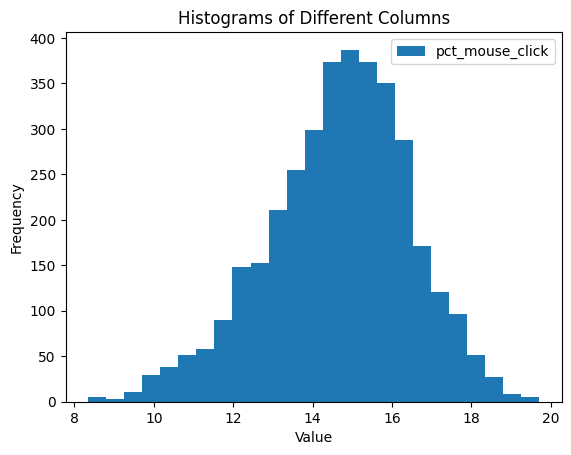

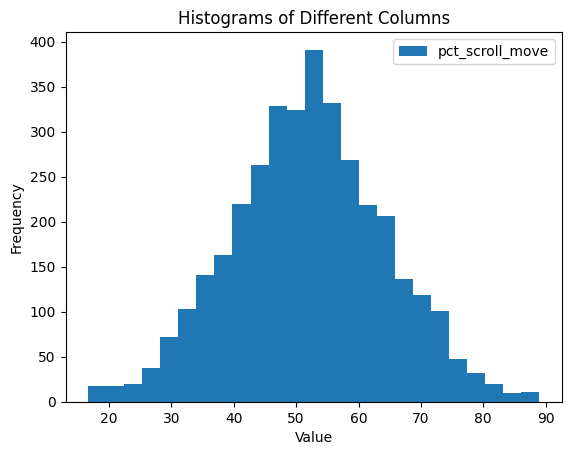

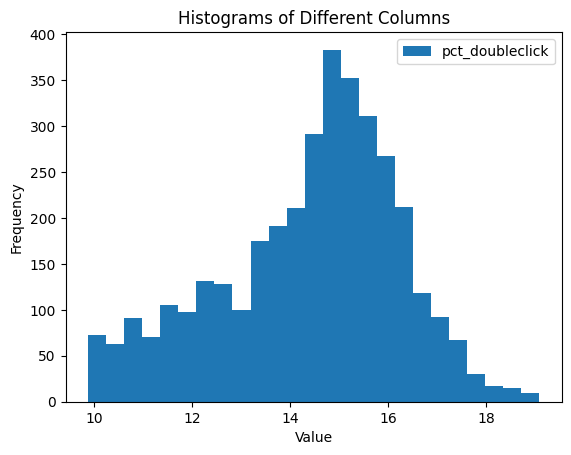

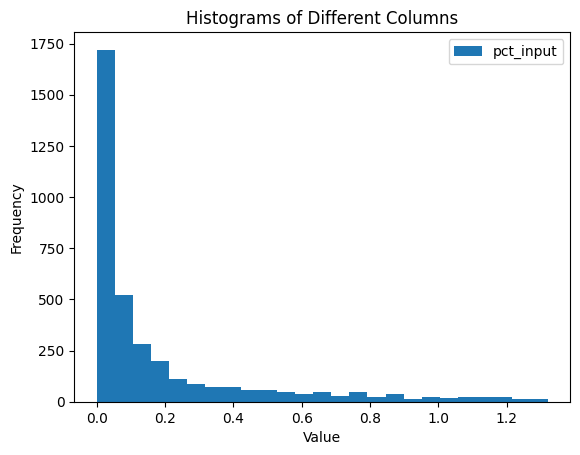

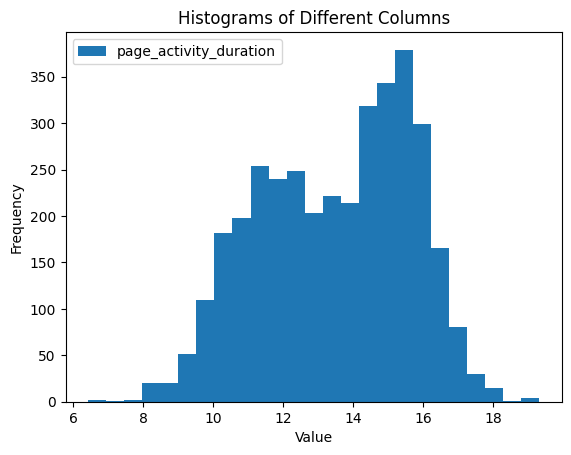

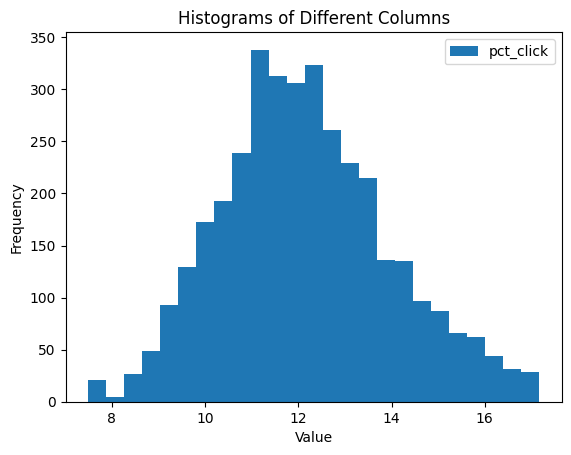

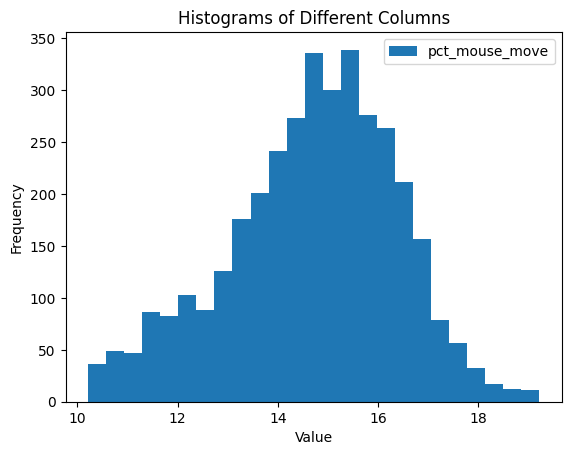

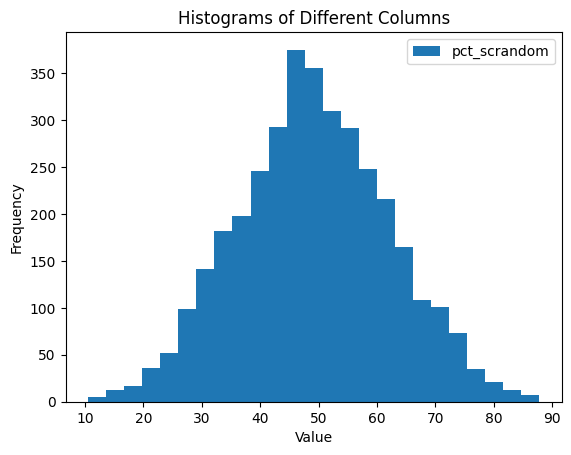

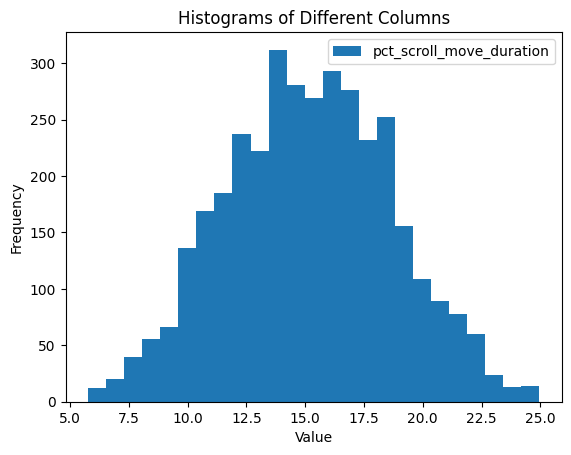

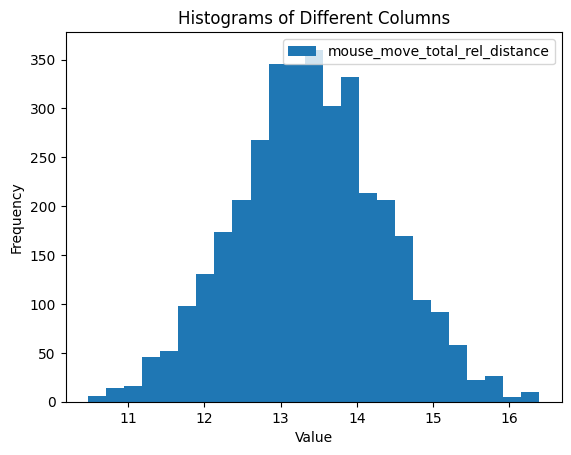

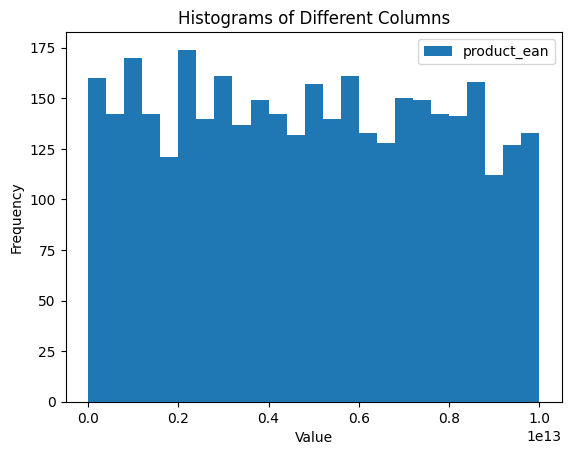

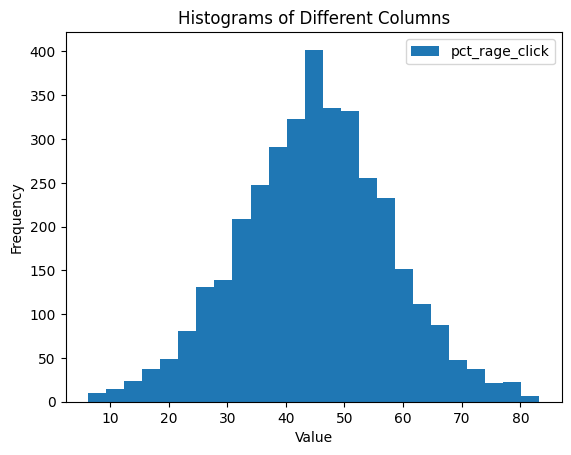

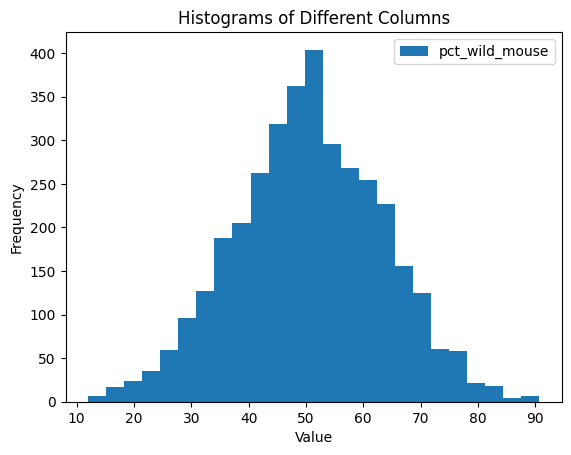

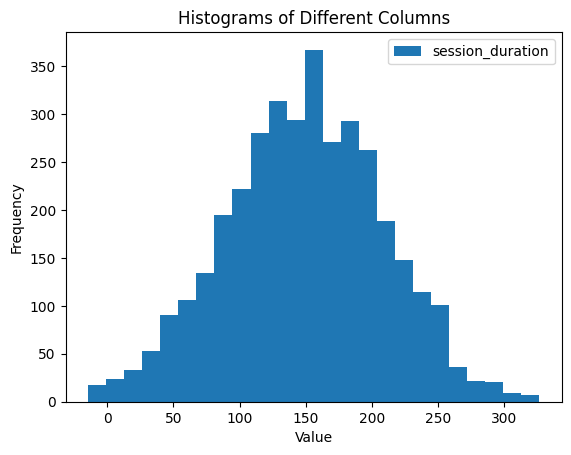

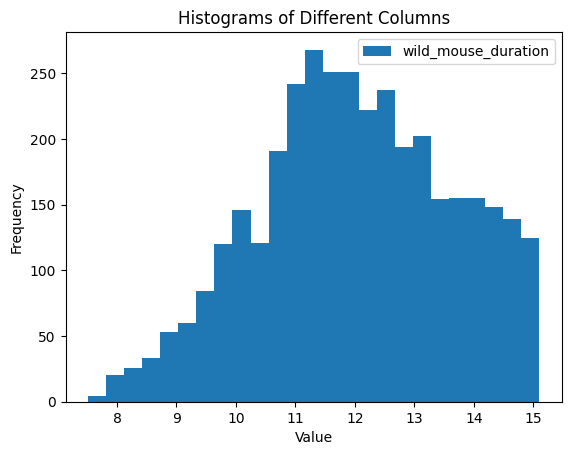

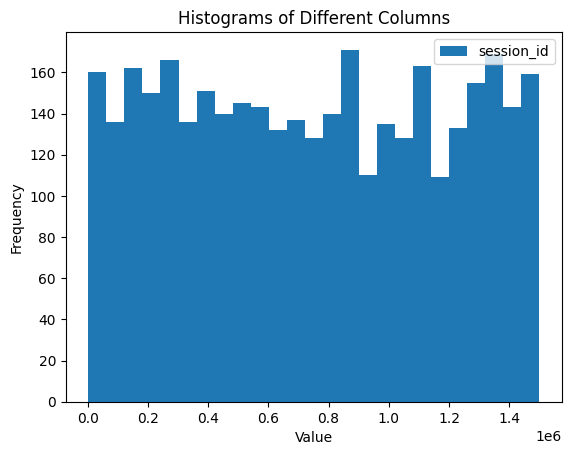

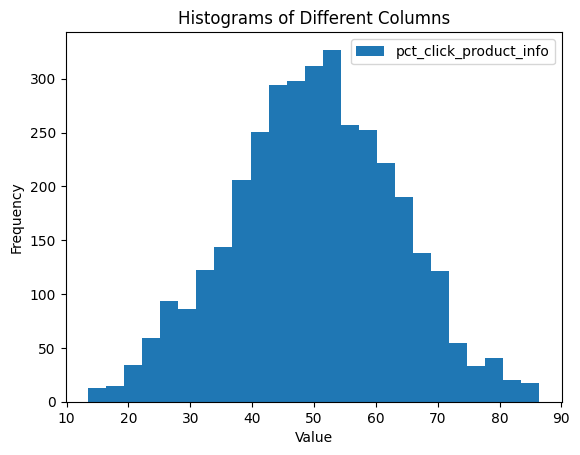

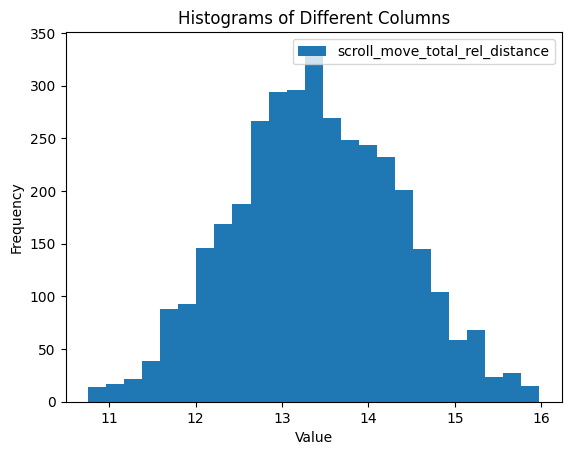

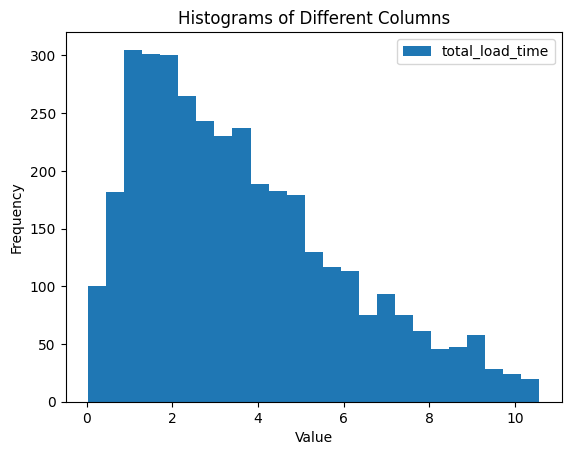

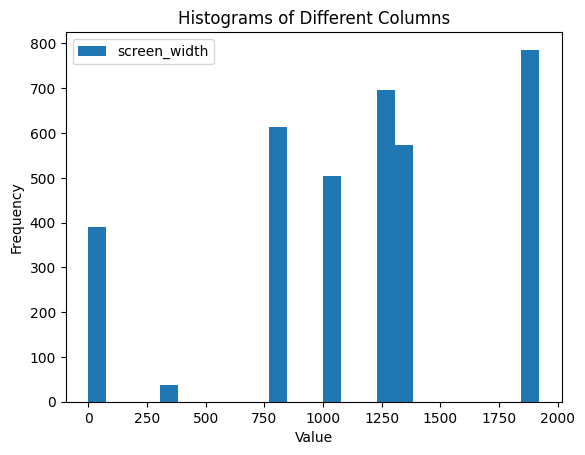

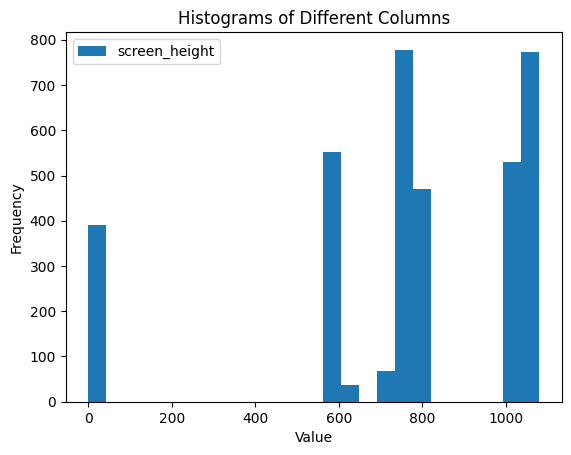

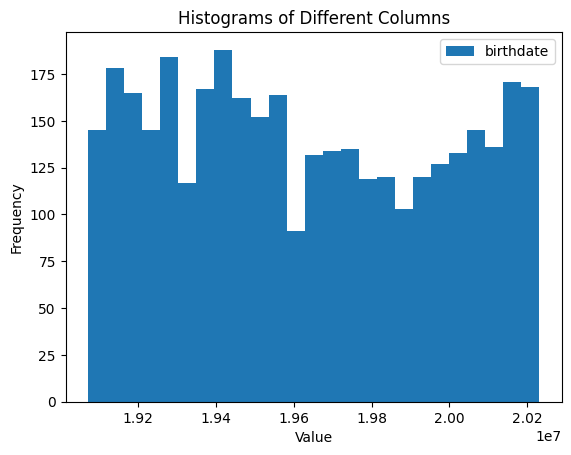

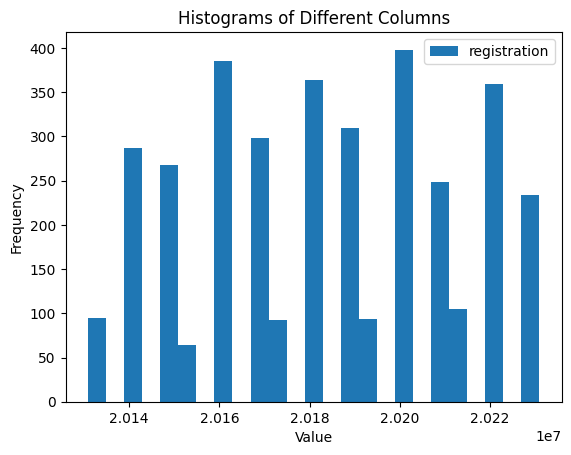

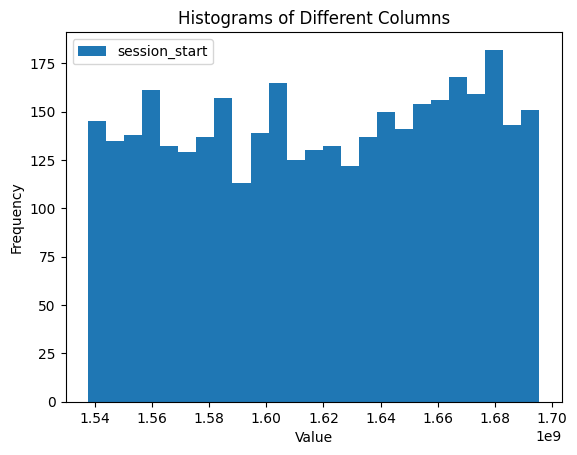

In [223]:
from matplotlib import pyplot

column_names = [
    'pct_mouse_click',
    'pct_scroll_move',
    'pct_doubleclick',
    'pct_input',
    'page_activity_duration',
    'pct_click',
    'pct_mouse_move',
    'pct_scrandom',
    'pct_scroll_move_duration',
    'mouse_move_total_rel_distance',
    'product_ean',
    'pct_rage_click',
    'pct_wild_mouse',
    'session_duration',
    'wild_mouse_duration',
    'session_id',
    'pct_click_product_info',
    'scroll_move_total_rel_distance',
    'total_load_time',
    'screen_width',
    'screen_height',
    'birthdate',
    'registration',
    'session_start'
]

for column in column_names:
    plt.hist(train_data[column], bins=25, label=column)

    # Add labels, legend, and show the plot
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of Different Columns')
    plt.legend()
    plt.show()

In [224]:
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_data)
train_data = pd.DataFrame(scaled_data, columns=train_data.columns)

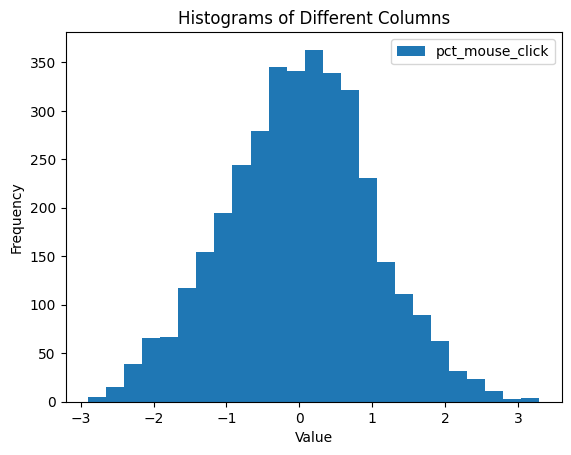

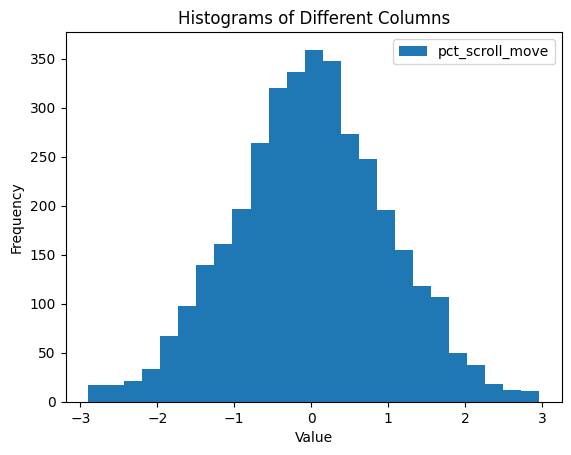

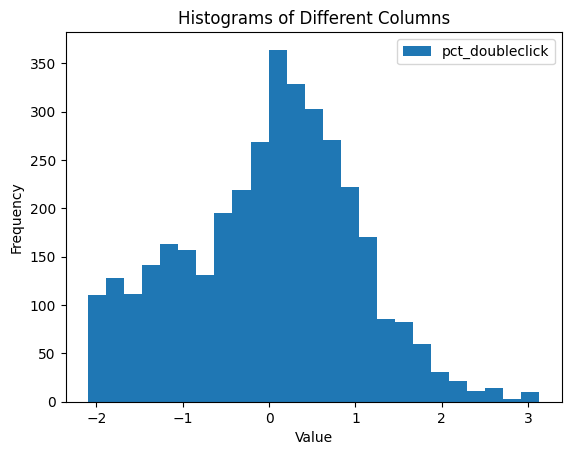

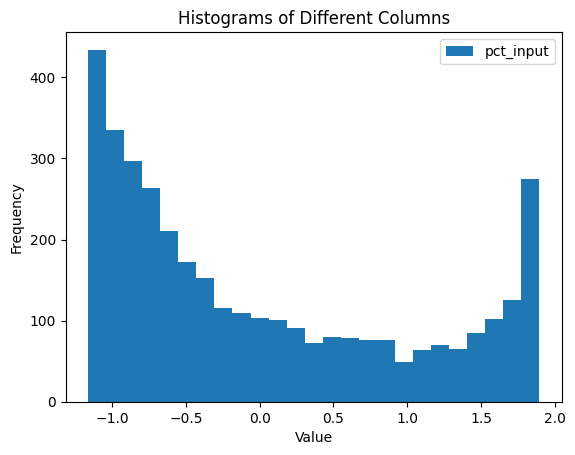

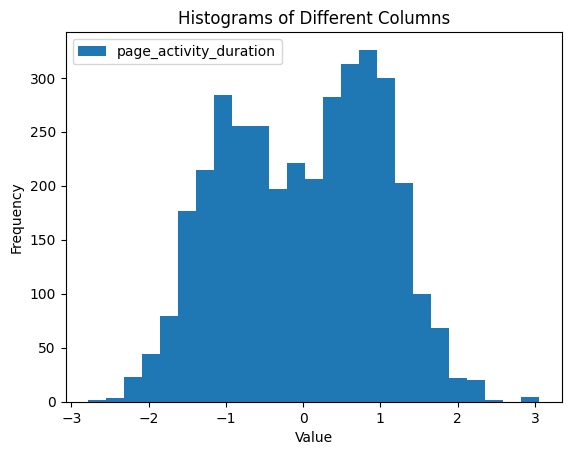

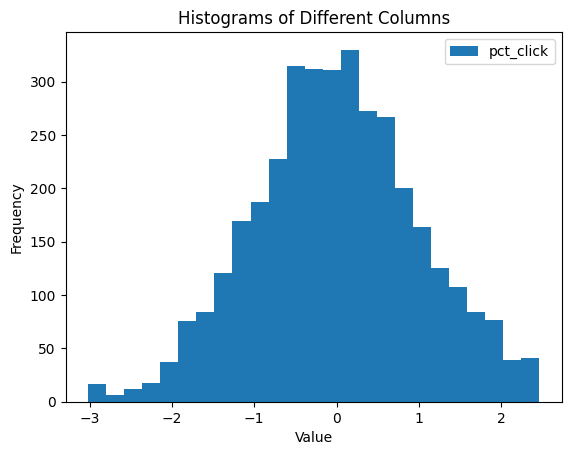

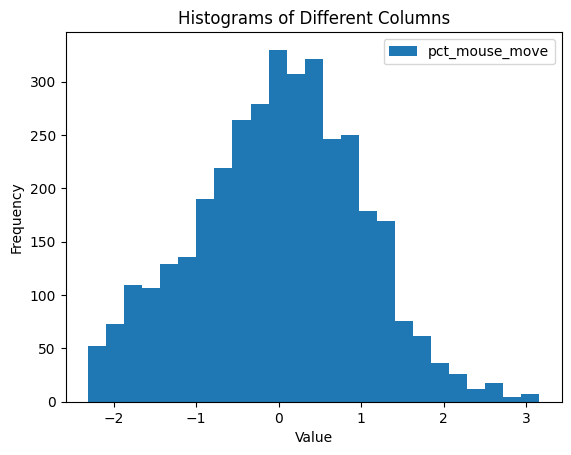

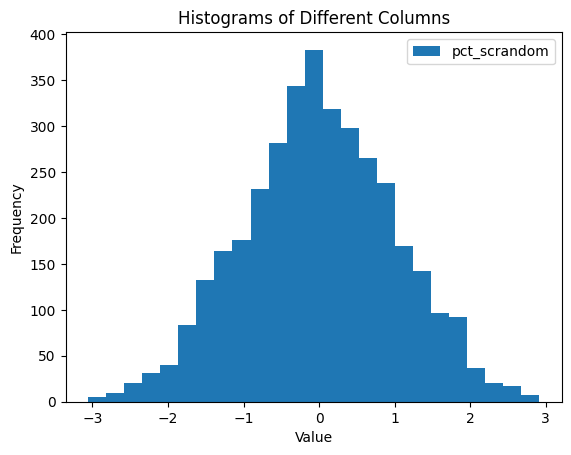

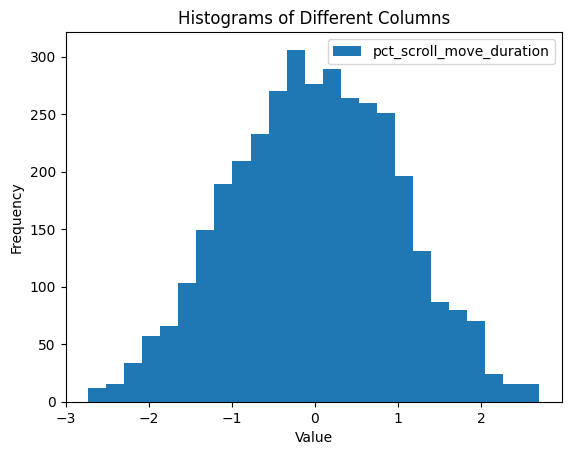

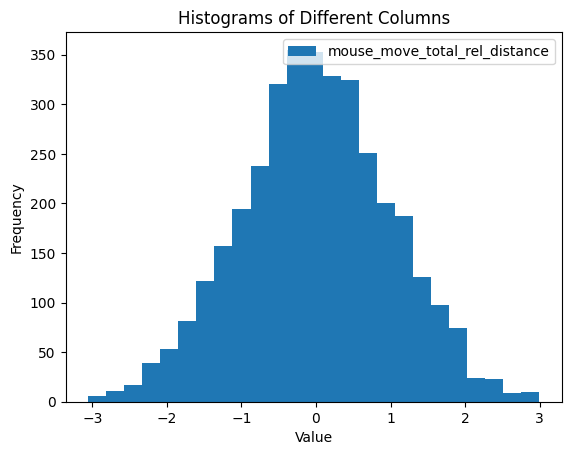

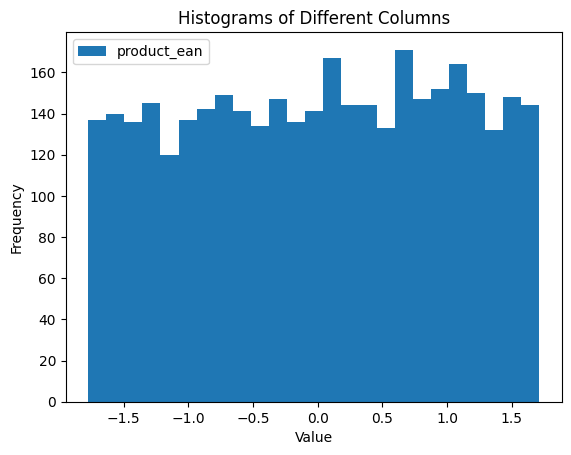

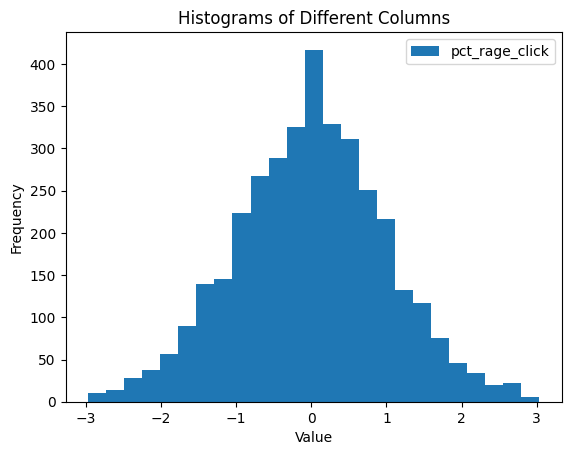

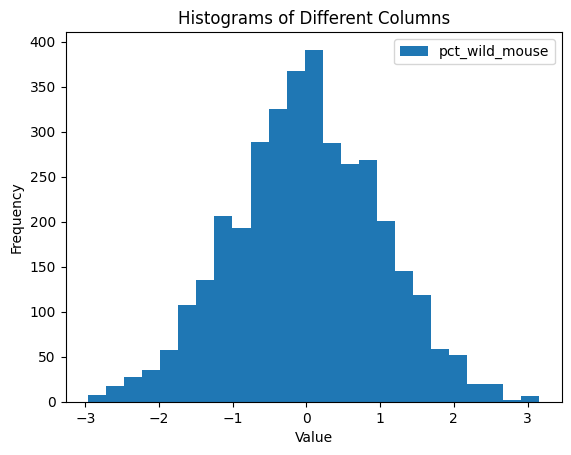

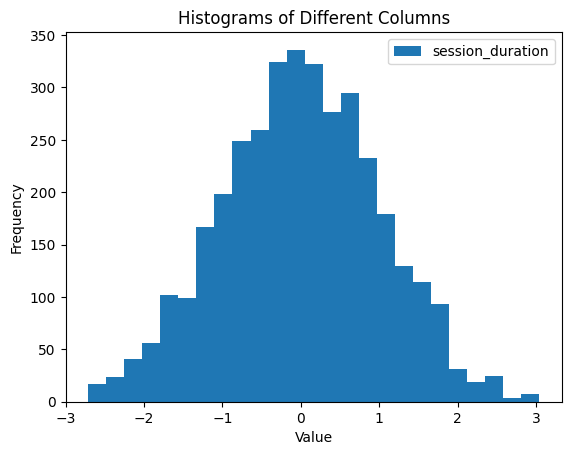

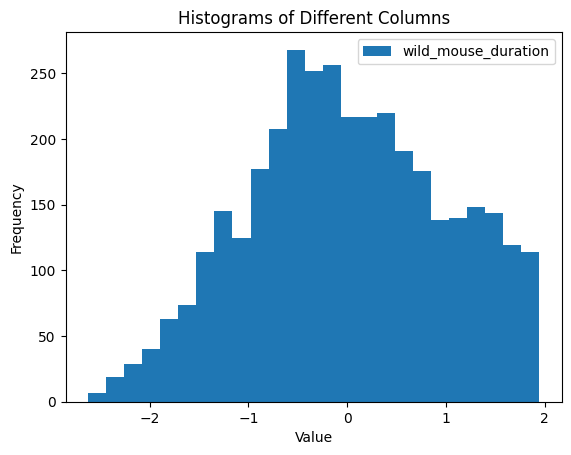

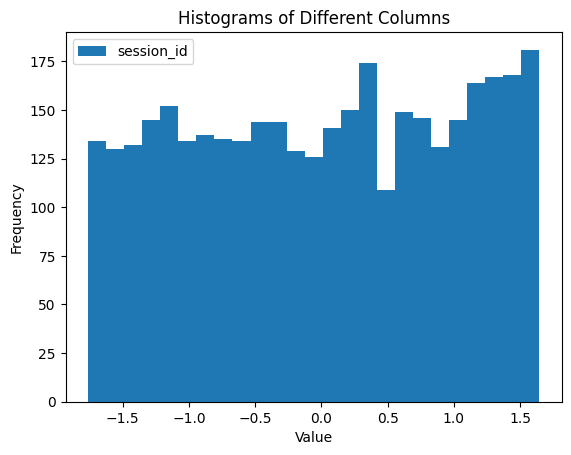

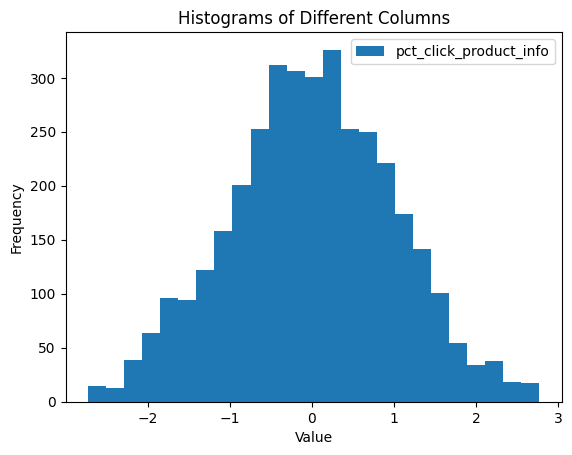

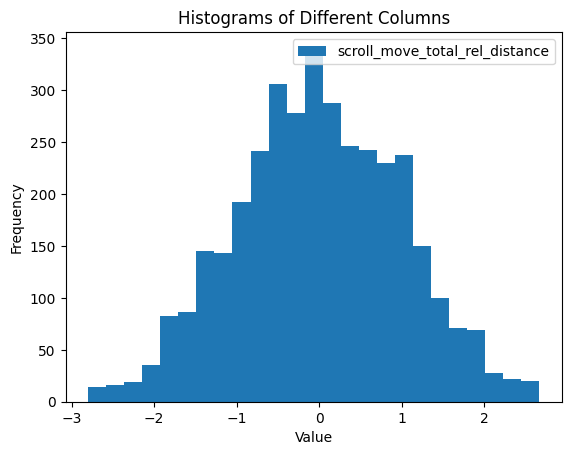

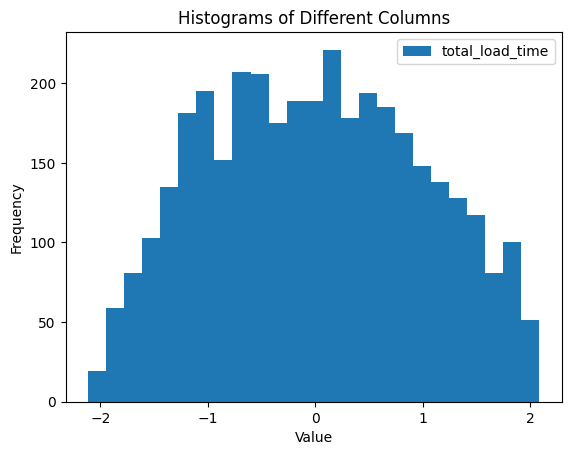

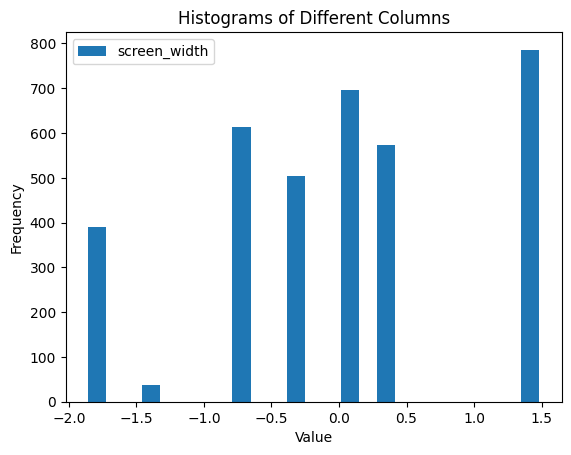

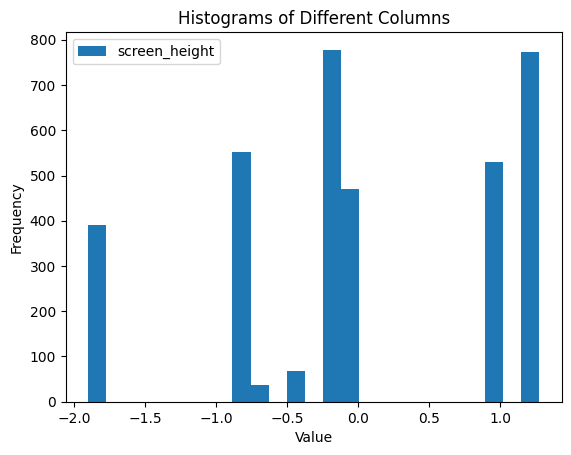

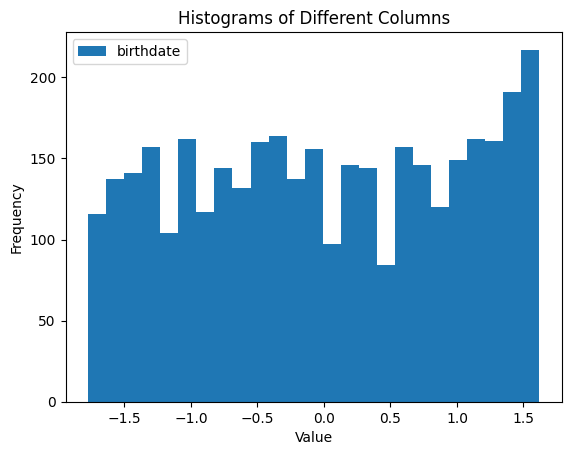

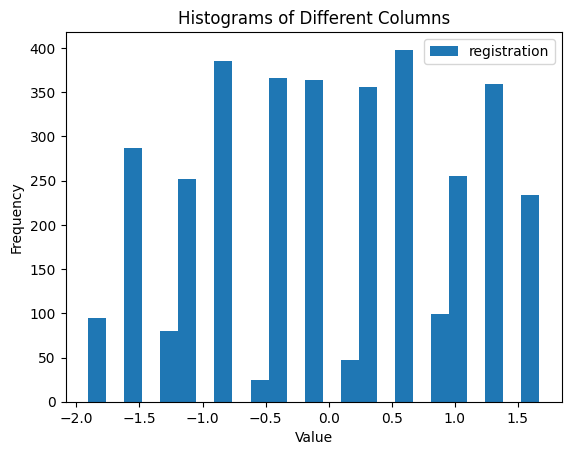

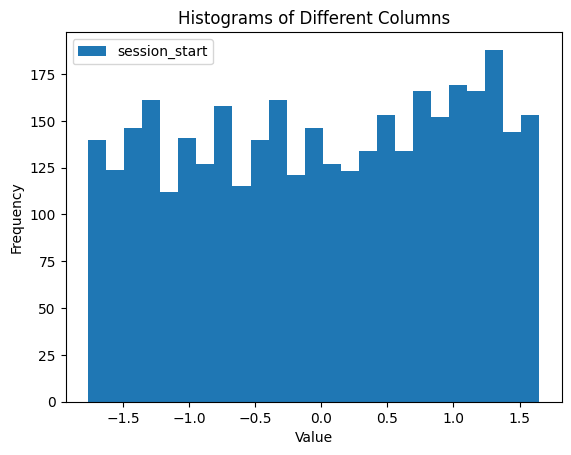

In [225]:
from sklearn.preprocessing import PowerTransformer


for column in column_names:
    power = PowerTransformer(method='yeo-johnson', standardize=True) 
    data_trans = power.fit_transform(train_data[[column]])

    pyplot.hist(data_trans, bins=25, label = column)
       
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of Different Columns')
    plt.legend()
    plt.show()

In [226]:
X_train.head()

,col_0,col_1,col_2,col_3,sex_F,sex_M,new_user_id,race_0,race_1,race_2,...,wild_mouse_duration,session_id,pct_click_product_info,scroll_move_total_rel_distance,total_load_time,screen_width,screen_height,birthdate,registration,session_start
0,0,1,0,0,1.0,0.0,782,0,0,1,...,14.24856,849729,23.91551,15.12649,7.79057,1280,1080,19650808.0,20200918.0,1570731284
4,1,0,0,0,1.0,0.0,2605,0,1,0,...,12.93290,781312,47.54284,14.08687,4.86658,1920,1080,19390123.0,20190605.0,1558918300
5,0,0,1,0,1.0,0.0,2605,0,1,0,...,9.69369,829814,59.59391,13.40058,2.31779,1024,768,19390123.0,20190605.0,1685228037
6,1,0,0,0,0.0,1.0,2675,0,1,0,...,12.93290,781312,47.54284,14.08687,4.86658,1920,1080,20140911.0,20181023.0,1558918300
7,0,0,1,0,0.0,1.0,2675,0,1,1,...,9.69369,829814,59.59391,13.40058,2.31779,1024,768,20140911.0,20181023.0,1685228037


### Záver

Dáta sme škálovali (scaling) pomocou MinMax scaleru, ktorý škáluje dáta do rozsahu od 0 do 1. Škálovanie pomáha zabezpečiť rýchlejšiu a stabilnejšiu konvergenciu.

Normalizovali sme dáta pomocu Power Transformeru.
Normalizácia vytvára distribúciu hodnôt, ktorá sa približuje k normálnej distribúcii. To môže byť užitočné pre niektoré štatistické metódy a modely, ktoré predpokladajú normálnu distribúciu dát.

### Výber atribútov (Feature selection) pre strojové učenie

#### Heatmap po transformácii

<Axes: >

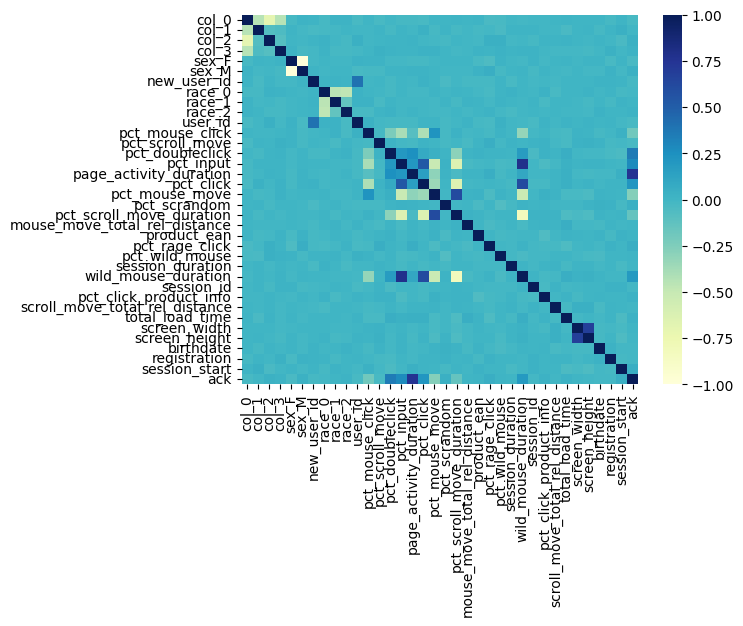

In [227]:
train_data_with_ack = pd.concat([X_train, y_train], axis=1)

# heatmap
correlation = train_data_with_ack.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=False, cmap="YlGnBu")

#### Hľadanie informatívnych atribútov a zoraďovanie podľa dôležitosti

V atribútoch sme našli 4 atribúty, ktoré nám udávajú nejaké identifikačné číslo, ktoré nám nepomôžu pri strojovom učení. Tieto atribúty sme pre to odstránili.

In [228]:
columns_to_drop = ['new_user_id', 'session_id', 'product_ean', 'user_id']
X_train = X_train.drop(columns=columns_to_drop)
column_names= X_train.columns.to_list()

In [229]:
best_features=None

##### 1. Wrapper feature selection using SelectFromModel and RandomForestClassifier

In [230]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Create a SelectFromModel object using a RandomForestClassifier estimator
selector = SelectFromModel(RandomForestClassifier()).fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the corresponding feature names
selected_features = [column_names[idx] for idx in selected_feature_indices]

# Get the ranking of features
ranking = selector.estimator_.feature_importances_

# Sort selected features by ranking
sorted_selected_features1 = sorted(selected_features, key=lambda x: abs(ranking[column_names.index(x)]), reverse=True)

# Print the sorted selected features
print("Sorted selected features:")
for feature in sorted_selected_features1:
    print(f"{feature}: {ranking[column_names.index(feature)]}")


Sorted selected features:
page_activity_duration: 0.5250348787343101
pct_doubleclick: 0.08789983007111624
wild_mouse_duration: 0.0423487895897367
pct_mouse_click: 0.038282208538423027
pct_click: 0.03824163695177526
pct_input: 0.03578240548487745


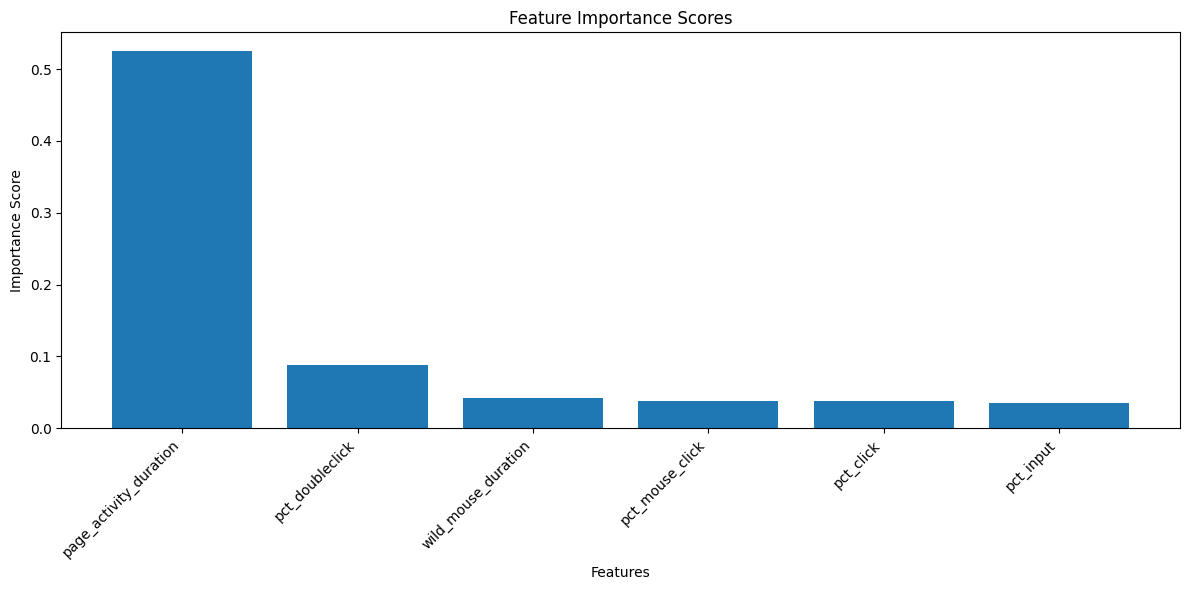

In [231]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_selected_features1)), [ranking[column_names.index(feature)] for feature in sorted_selected_features1])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Scores')
plt.xticks(range(len(sorted_selected_features1)), sorted_selected_features1, rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 2. Filter feature selection using SelectKBest and f_regression

In [232]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Create a SelectKBest object using mutual_info_regression estimator
X_new = SelectKBest(mutual_info_regression)
X_new = X_new.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = X_new.get_support(indices=True)

# Get the corresponding feature names
selected_features = [column_names[idx] for idx in selected_feature_indices]

# Get the ranking of features
ranking = X_new.scores_

# Sort selected features by ranking
sorted_selected_features2 = sorted(selected_features, key=lambda x: abs(ranking[column_names.index(x)]), reverse=True)

# Print the sorted selected features
print("Sorted selected features:")
for feature in sorted_selected_features2:
    print(f"{feature}: {ranking[column_names.index(feature)]}")


Sorted selected features:
page_activity_duration: 0.4479873729014665
pct_doubleclick: 0.16052098701399053
wild_mouse_duration: 0.14711431313961754
pct_click: 0.1437774717821485
pct_mouse_move: 0.14279378050297087
pct_input: 0.1374478139918942
pct_mouse_click: 0.12667974579422925
session_start: 0.12431233219686444
scroll_move_total_rel_distance: 0.1173292894617779
pct_scroll_move: 0.1158669149455811


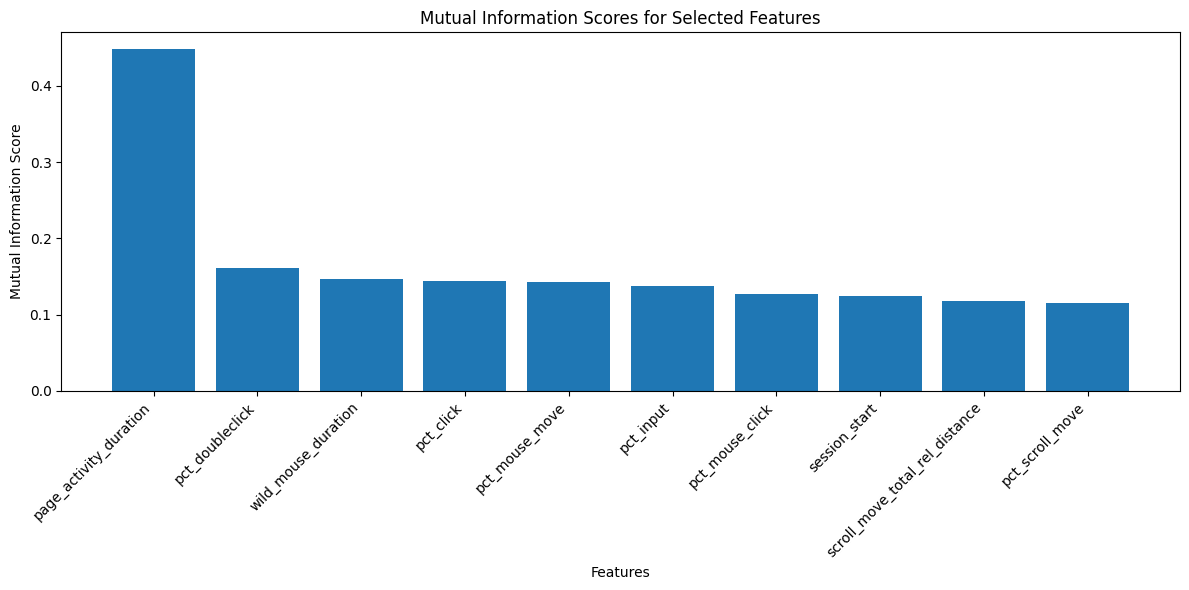

In [233]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_selected_features2)), [ranking[column_names.index(feature)] for feature in sorted_selected_features2])
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Selected Features')
plt.xticks(range(len(sorted_selected_features2)), sorted_selected_features2, rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Zhodnotenie metód výberu atribútov

Rozhodli sme sa využiť kombináciu wrapper a filter metód pre výber atribútov. Wrapper metódy boli zvolené s cieľom zohľadniť zložité vzťahy medzi atribútmi, špecifikovať algoritmy a dosiahnuť čo najlepšiu presnosť modelu. Na druhej strane, filter metódu sme integrovali pre jej výpočtovú efektivitu a nezávislosť od konkrétnych modelov, čo je ideálne pre situácie s veľkým počtom atribútov.

Po porovnaní vybraných atribútov z jednotlivých metód sme zistili, že sa skoro vôbec nelíšia. V druhej metóde však boli identifikované atribúty, ktoré boli v prvej metóde vynechané. Avšak, pri porovnaní týchto atribútov s heatmapou sme zistili, že doplnkové atribúty vybrané v druhej metóde nemajú výrazný vplyv na predikciu. Preto sme sa rozhodli uprednostniť atribúty z prvej metódy, ktoré sú výrazne informatívnejšie a majú väčší vplyv na predikciu.

V oboch prípadoch výberu príznakov vynikol page_activity_duration, ktorý mal 2 až 3-krát väčšiu hodnotu ako ostatné príznaky. Tento jav zdôrazňuje význam a výrazný prínos tohto konkrétneho atribútu v oboch prístupoch. 

In [234]:
for i,feature in enumerate(sorted_selected_features2):
    print(i+1, feature)

best_features = sorted_selected_features2

1 page_activity_duration
2 pct_doubleclick
3 wild_mouse_duration
4 pct_click
5 pct_mouse_move
6 pct_input
7 pct_mouse_click
8 session_start
9 scroll_move_total_rel_distance
10 pct_scroll_move


Pre tieto features sme sa rozhodli vytvoriť nový dataset, ktorý bude obsahovať len tieto atribúty. Myslíme si, že bude potrebný v ďalšej fáze projektu.

In [235]:
for column in X_train.columns:
    if column not in best_features:
        X_train.drop(column, axis=1, inplace=True)
        
X_train.to_csv('best_features_train.csv', index=False)


### Replikovateľnosť predspracovania

Na predspracovanie testovacej množiny sme použili rovnaké metódy a postupy ako na trénovaciu množinu, s tým rozdielom, že sme použili len tie atribúty, ktoré sme získali v predchádzajúcom kroku. Toto sme spravili pomocou knižnice sklearn, pomocou Pipeline a make_column_transformer. Stačilo nám použiť len 2 techniky, lebo ostatné atribúty boli už numerické, keďže sme ich predtým transformovali a opravili na mergnutom datasete, v prvej časti 2. fázy projektu.

In [236]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

In [237]:
test_data = pd.read_csv("X_test.csv", sep=',')
features_test_data=None

for column in test_data.columns:
    if column in best_features:
        features_test_data = pd.concat([features_test_data, test_data[column]], axis=1)

best_features_test_data_names = features_test_data.columns.to_list()    

In [238]:
best_features_indices = [features_test_data.columns.get_loc(c) for c in best_features_test_data_names if c in test_data.columns]

In [239]:
minmax_scaler = make_column_transformer((MinMaxScaler(), best_features_indices), remainder='passthrough')

In [240]:
power_transformer = make_column_transformer((PowerTransformer(method='yeo-johnson', standardize=True), best_features_indices), remainder='passthrough')

In [241]:
pp = Pipeline(steps=[('1',minmax_scaler),
                     ('2',power_transformer)], verbose=True)

In [242]:


#transformed = pp.fit_transform(features_test_data)
#pp.fiit_transform(train_data)
#transformed = pp.transform(features_test_data)

pp_transformed_train = pp.fit_transform(X_train, y_train)
pp_transformed_test = pp.fit_transform(features_test_data, y_test)


[Pipeline] ................. (step 1 of 2) Processing 1, total=   0.0s
[Pipeline] ................. (step 2 of 2) Processing 2, total=   0.0s


,pct_mouse_click,pct_scroll_move,pct_doubleclick,pct_input,page_activity_duration,pct_click,pct_mouse_move,wild_mouse_duration,scroll_move_total_rel_distance,session_start
0,0.481169,0.409490,0.559723,-1.005503,0.549198,-1.143384,-0.092904,-1.092134,-0.246421,1.584410
1,0.345430,-1.038849,1.364377,-0.551245,0.237181,-1.185867,-0.383634,-0.245928,-0.161906,-1.588422
2,-1.594231,-0.603491,0.098989,0.624895,1.827463,1.775120,-1.183831,0.629654,1.224540,1.285908
3,-0.233001,-0.392069,0.376982,1.890722,-1.655196,0.988920,-0.517045,1.885903,-0.592262,1.153480
4,0.291187,2.071682,0.388738,-0.643769,-0.480647,0.118221,-0.087232,-0.360668,-2.134801,0.000815


Takto transformované dáta sme uložili do súboru "best_features_test.csv".

In [ ]:
pp_transformed_train.head()

In [ ]:
pp_transformed_test.head()

In [243]:
new_test_data.to_csv('best_features_test.csv', index=False)

### Záver

Po integračnom a čistiacom procese dát sme úspešne transformovali dáta do formátu vhodného pre strojové učenie. Riešili sme chýbajúce a vychýlené hodnoty, predspracovali dáta a vybrali najviac informatívne atribúty. Replikovateľnosť sme zabezpečili pomocou sklearn.pipeline, pripravujúc dáta pre ďalšie modelovanie.

### Zdroje
- https://github.com/FIIT-IAU/IAU-course
- https://machinelearningmastery.com/calculate-feature-importance-with-python/
- https://github.com/PeterPlevko/STU-FIIT/tree/main/Inteligentn%C3%A1%20anal%C3%BDza%20%C3%BAdajov